In [1]:
import os
import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

import torch
import gpytorch

In [2]:
data_folder = 'Data_SNIa_LSST/'
df_data = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
# dfs = pd.read_csv(data_folder+'hubble_diagram_Sr.txt', skiprows=4, sep=' ')
# Np = len(dfp.values)
# Ns= len(dfs.values)
df_data.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [3]:
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values
df_data.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01643
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01168
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.02837
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01996
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01658


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


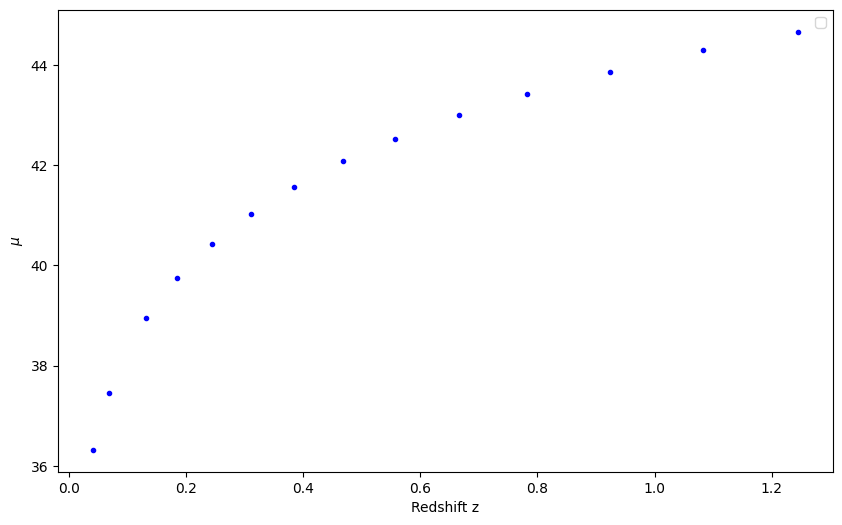

In [4]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(df_data['zCMB'].values, df_data['MU'].values, yerr=df_data['errors'].values, fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [5]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [6]:
len(df_data)

14

In [7]:
df_data.head()

,zCMB,MU,errors
0,0.04131,36.31666,0.01643
1,0.06876,37.44798,0.01168
2,0.13121,38.94492,0.02837
3,0.18499,39.75545,0.01996
4,0.24503,40.42469,0.01658


In [8]:
z = df_data[['zCMB']].values
y = df_data[['MU', 'errors']].values

randomize = np.random.permutation(len(z))
z = z[randomize]
y = y[randomize]
len(z), len(y)

(14, 14)

In [9]:
zmin, zmax = np.min(z), np.max(z)
zmin, zmax

(0.04131, 1.24447)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


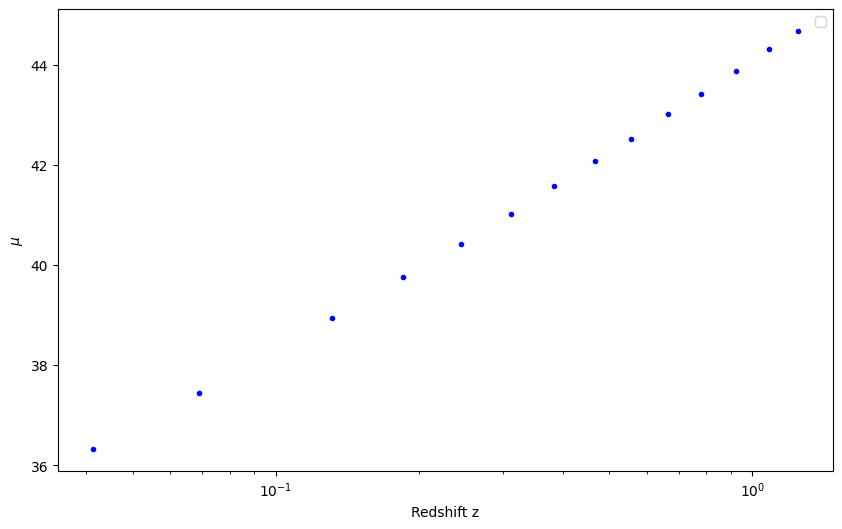

In [10]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:, 0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.xscale('log')
plt.legend()

In [11]:
# split = 0.8
# ntrain = int(split * len(z))
# indx = [ntrain]
# z_train, z_test = np.split(z, indx)
# y_train, y_test = np.split(y, indx)

In [12]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 1.3, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [13]:
# yy = y[:,0].reshape(-1,1)
# zz = z
# split = 0.8
# ntrain = int(split * len(zz))
# indx = [ntrain]
# zz_train, zz_test = np.split(zz, indx)
# yy_train, yy_test = np.split(yy, indx)
# yy_train = np.append(yy_train, np.array([y[0], y[-1]]))
# zz_train = np.append(zz_train, np.array([z[0], z[-1]]))
np.shape(z), np.shape(y), np.shape(z), np.shape(y)

((14, 1), (14, 2), (14, 1), (14, 2))

In [14]:
# x_train = torch.tensor(z_train).reshape(len(z_train),)
# y_train = torch.tensor(y_train)

z_torch = torch.from_numpy(z).float()
y_torch = torch.from_numpy(y).float()

In [15]:
len(z)

14

In [16]:
np.shape(z), np.shape(y)

((14, 1), (14, 2))

In [17]:
# Definir el modelo de proceso gaussiano
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(z_torch, y_torch, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
#             gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
            gpytorch.kernels.MaternKernel(nu=1.5, lengthscale=2), num_tasks=2, rank=1
#             gpytorch.kernels.SpectralMixtureKernel(num_mixtures=2), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(z_torch, y_torch, likelihood)

In [18]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 100
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(z_torch)
    loss = -mll(output, y_torch)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

/home/isidro/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iter 1/100 - Loss: 14.739
Iter 2/100 - Loss: 12.768
Iter 3/100 - Loss: 11.250
Iter 4/100 - Loss: 10.077
Iter 5/100 - Loss: 9.155
Iter 6/100 - Loss: 8.409
Iter 7/100 - Loss: 7.787
Iter 8/100 - Loss: 7.254
Iter 9/100 - Loss: 6.788
Iter 10/100 - Loss: 6.379
Iter 11/100 - Loss: 6.016
Iter 12/100 - Loss: 5.694
Iter 13/100 - Loss: 5.409
Iter 14/100 - Loss: 5.156
Iter 15/100 - Loss: 4.931
Iter 16/100 - Loss: 4.731
Iter 17/100 - Loss: 4.551
Iter 18/100 - Loss: 4.390
Iter 19/100 - Loss: 4.244
Iter 20/100 - Loss: 4.111
Iter 21/100 - Loss: 3.989
Iter 22/100 - Loss: 3.876
Iter 23/100 - Loss: 3.770
Iter 24/100 - Loss: 3.671
Iter 25/100 - Loss: 3.577
Iter 26/100 - Loss: 3.487
Iter 27/100 - Loss: 3.401
Iter 28/100 - Loss: 3.319
Iter 29/100 - Loss: 3.239
Iter 30/100 - Loss: 3.162
Iter 31/100 - Loss: 3.088
Iter 32/100 - Loss: 3.017
Iter 33/100 - Loss: 2.947
Iter 34/100 - Loss: 2.880
Iter 35/100 - Loss: 2.815
Iter 36/100 - Loss: 2.751
Iter 37/100 - Loss: 2.690
Iter 38/100 - Loss: 2.630
Iter 39/100 - Los

In [19]:
minrange = zmin
maxrange = zmax
x_test = torch.linspace(0, 1.3, 50)
np.shape(x_test)

torch.Size([50])

In [20]:
zmin, zmax

(0.04131, 1.24447)

In [21]:
x_test = x_test.reshape(len(x_test), )
# x_test = torch.from_numpy(x_test).float()
np.shape(x_test), type(x_test)

(torch.Size([50]), torch.Tensor)

In [22]:
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [23]:
f_preds = model(x_test)

In [24]:
type(f_preds)

gpytorch.distributions.multitask_multivariate_normal.MultitaskMultivariateNormal

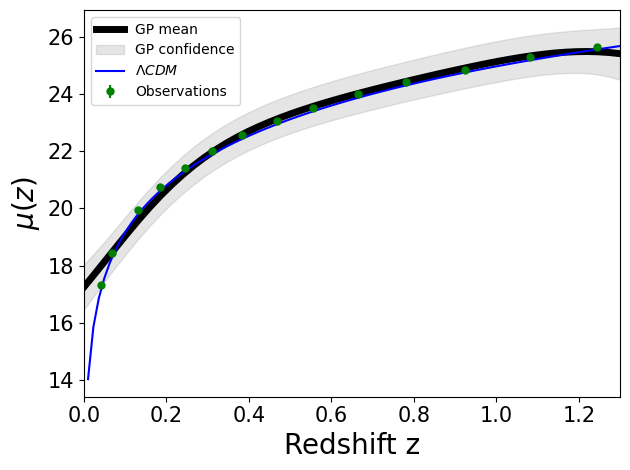

In [25]:
# # The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# # See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Obtain the predictive mean and covariance matrix
    f_preds = model(x_test)
    f_mean_mu = f_preds.mean[:, 0]
    f_mean_err = f_preds.mean[:, 1]
    f_cov = f_preds.covariance_matrix
    # Make predictions by feeding model through likelihood
    observed_pred = likelihood(model(x_test))
#     print(type(observed_pred))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    lower_mu = lower[:, 0]
    upper_mu = upper[:, 0]
    lower_err = lower[:, 0]
    upper_err = upper[:, 0]
    observed_pred_mean_mu = observed_pred.mean.numpy()[:, 0]
    observed_pred_mean_err = observed_pred.mean.numpy()[:, 1]
#     print(observed_pred.mean.numpy())
    plt.plot(x_test.numpy(), observed_pred_mean_mu-19, color='k', label='GP mean', linewidth=5)
#     # Shade between the lower and upper confidence bounds
    plt.fill_between(x_test.numpy(), lower_mu-19, upper_mu-19, alpha=0.2, label='GP confidence', color='gray')
#     plt.errorbar(x_test.numpy(), observed_pred_mean_mu-19, yerr=observed_pred_mean_err)

plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=10, label='Observations')


plt.xlim(0,1.3)

plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

In [26]:
np.shape(x_test.numpy()), np.shape(observed_pred_mean_mu), np.shape(observed_pred_mean_err)

((50,), (50,), (50,))

# Single output 1D and cov matrix

In [64]:
class GaussianProcess(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(GaussianProcess, self).__init__(x_train, y_train, likelihood)
        self.mean = gpytorch.means.ConstantMean() # Construct the mean function
#         self.cov = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=2) # Construct the kernel function
#         self.cov = gpytorch.kernels.RBFKernel()
        self.cov = gpytorch.kernels.MaternKernel(nu=1.5, lengthscale=0.5)
#             gpytorch.kernels.SpectralMixtureKernel(num_mixtures=2), num_tasks=2, rank=1
        # Comment the following for RBF Kernel and Matern Kernel
#         self.cov.initialize_from_data(x_train, y_train) # Initialize the hyperparameters from data
        
    def forward(self, x):
        # Evaluate the mean and kernel function at x
        mean_x = self.mean(x)
        cov_x = self.cov(x)
        # Return the multivariate normal distribution using the evaluated mean and kernel function
        return gpytorch.distributions.MultivariateNormal(mean_x, cov_x)        


In [73]:
# Initialize the likelihood and model
# likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
likelihood2 = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(
                                noise=y_torch[:, 1],
                                learn_additional_noise=False)



model2 = GaussianProcess(z_torch, y_torch[:, 0], likelihood2)

In [74]:
# Put the model into training mode
model2.train()
likelihood2.train()

# Use the Adam optimizer, with learning rate set to 0.1
optimizer = torch.optim.Adam(model2.parameters(), lr=0.1)

# Use the negative marginal log-likelihood as the loss function
mll2 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, model2)

# Set the number of training iterations
n_iter = 100

In [75]:
for i in range(n_iter):
    # Set the gradients from previous iteration to zero
    optimizer.zero_grad()
    # Output from model
    output = model2(z_torch)
    # Compute loss and backprop gradients
#     loss = -mll(output, y_train.reshape(-1,1))
    loss = -mll2(output, y_torch[:, 0].reshape(-1,1)).mean()  # or .sum()
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 101.975
Iter 2/100 - Loss: 98.318
Iter 3/100 - Loss: 94.983
Iter 4/100 - Loss: 91.944
Iter 5/100 - Loss: 89.174
Iter 6/100 - Loss: 86.649
Iter 7/100 - Loss: 84.345
Iter 8/100 - Loss: 82.240
Iter 9/100 - Loss: 80.315
Iter 10/100 - Loss: 78.552
Iter 11/100 - Loss: 76.933
Iter 12/100 - Loss: 75.444
Iter 13/100 - Loss: 74.072
Iter 14/100 - Loss: 72.803
Iter 15/100 - Loss: 71.627
Iter 16/100 - Loss: 70.534
Iter 17/100 - Loss: 69.515
Iter 18/100 - Loss: 68.563
Iter 19/100 - Loss: 67.670
Iter 20/100 - Loss: 66.831
Iter 21/100 - Loss: 66.040
Iter 22/100 - Loss: 65.292
Iter 23/100 - Loss: 64.583
Iter 24/100 - Loss: 63.909
Iter 25/100 - Loss: 63.267
Iter 26/100 - Loss: 62.654
Iter 27/100 - Loss: 62.066
Iter 28/100 - Loss: 61.503
Iter 29/100 - Loss: 60.961
Iter 30/100 - Loss: 60.440
Iter 31/100 - Loss: 59.936
Iter 32/100 - Loss: 59.449
Iter 33/100 - Loss: 58.978
Iter 34/100 - Loss: 58.520
Iter 35/100 - Loss: 58.076
Iter 36/100 - Loss: 57.644
Iter 37/100 - Loss: 57.223
Iter 38/1

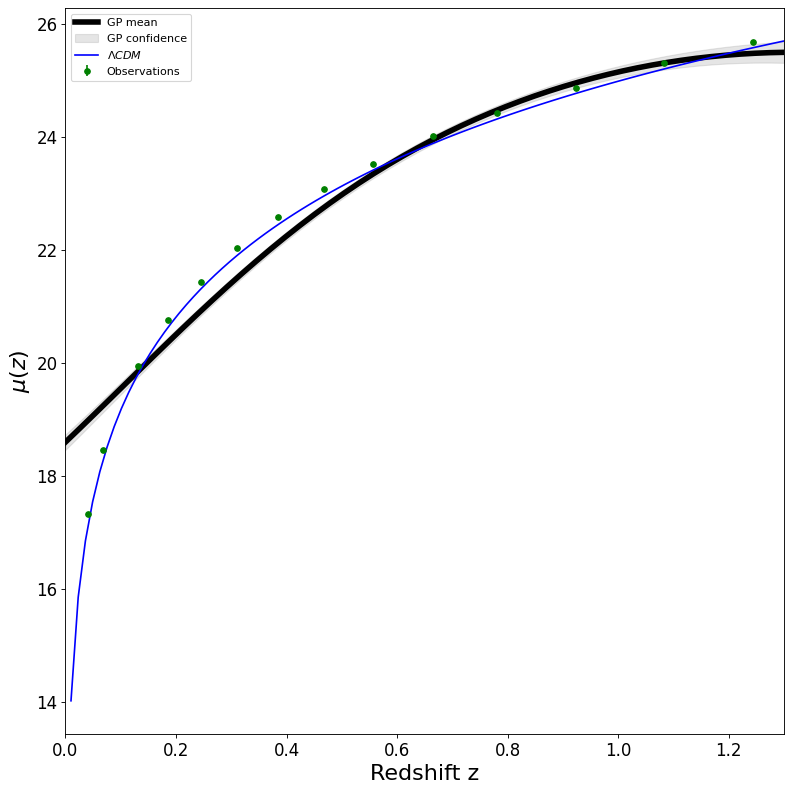

In [76]:
# Plotting
# plt.figure(figsize=(5, 4), dpi=100)
# The test data is 50 equally-spaced points
x_test = torch.linspace(0, 1.3, 50)
# Put the model into evaluation mode
model2.eval()
likelihood2.eval()

fig = plt.figure(figsize=(10, 10), dpi=80)

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Obtain the predictive mean and covariance matrix
    f_preds = model2(x_test)
    f_mean = f_preds.mean
    f_cov = f_preds.covariance_matrix
    # Make predictions by feeding model through likelihood
    observed_pred = likelihood2(model2(x_test))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    plt.plot(x_test.numpy(), observed_pred.mean.numpy()-19, color='k', label='GP mean', linewidth=5)
    # Shade between the lower and upper confidence bounds
    plt.fill_between(x_test.numpy(), lower.numpy()-19, upper.numpy()-19, alpha=0.2, label='GP confidence', color='gray')


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
#              ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
#              label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

# zCMB 	MU 	errors